In [1]:
import sys, os
import numpy as np
from numpy.linalg import LinAlgError, inv
from scipy.linalg import sqrtm

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
sys.path.append(r"C:\Users\super\DAG")
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print(os.getcwd())

import torch
import torch.nn as nn
from torch.optim import Adam, LBFGS
from nodag_gumbel_softmax import train_gumbel_sgd, train_gs_reset
from SCM_data import generate_scm_data
import numpy as np
from numpy.linalg import LinAlgError, inv
from scipy.linalg import sqrtm
import MEC

c:\Users\super\DAG\nodag


In [11]:
# ER1, d=4
import logging
import numpy as np

from torch.utils.data import Dataset

from synthetic_dataset import SyntheticDataset
from synthetic_dataset import dataset_based_on_B


# Load dataset
n, d = 10000, 4
graph_type, degree = 'ER', 1    # ER1 graph
B_scale = 1.0
noise_type = 'gaussian_ev'

Dataset = SyntheticDataset(n, d, graph_type, degree,
                          noise_type, B_scale, seed=7)
data = Dataset.X
R_hat = np.cov(data.T)
print(R_hat.shape)
d = R_hat.shape[0]
Omega_true = np.eye(d)
Theta_hat = inv(R_hat)
# A_init = np.linalg.cholesky(Theta_hat)
# A_init = A_init + 0.01 * np.random.randn(*A_init.shape)
np.random.seed(54)
B_init = np.random.randn(*R_hat.shape)
B_true = Dataset.B
G_true = Dataset.B_bin
beta = 5
lam = 0.5



A_true = (np.eye(d) - B_true) @ inv(sqrtm(Omega_true))
print("G_true = \n",G_true)
likelihood_true = - 2 * np.log(np.linalg.det(A_true)) + np.trace(A_true.T @ R_hat @ A_true)
print("likelihood_true = ", likelihood_true)
true_penalty = lam * np.count_nonzero(A_true[~np.eye(A_true.shape[0], dtype=bool)])
f_true = likelihood_true + true_penalty

B_final,G_final, info = train_gumbel_sgd(
    Rhat_np = R_hat,
    lam = lam,
    delta = 1e-6,
    tau_start = 1,
    tau_end = 1,
    B_init = B_init,
    max_steps = 5000,
    history_every=10,
    seed = 2
)
    
print("G_est = \n",G_final)


eps = 1e-6
abs_B = np.clip(np.abs(B_init), eps, 1 - eps)

# 计算 U_init = logit(|B_init|)
U_init = np.log(abs_B / (1 - abs_B))

# 计算 P_init = sign(B_init) * |B_init|
P_init = np.sign(B_init) * abs_B

# 打印结果
print("U_init =\n", np.round(U_init,2))
print("P_init =\n",np.round(B_init,2))

print("U_final = \n", np.array2string(info["U_final"], formatter={'float_kind':lambda x: f"{x:.2f}"}))
print("P_final = \n", np.array2string(info["P_final"], formatter={'float_kind':lambda x: f"{x:.2f}"}))
print("Final Loss = ", info["final_loss"])
print("Final penalty = ", info["final_penalty"])
print("Final likelihood = ", info["final_likelihood"])
print("likelihood_true = ", likelihood_true)


(4, 4)
G_true = 
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]
likelihood_true =  4.01259352685402
G_est = 
 [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]]
U_init =
 [[13.82 13.82 -2.46 13.82]
 [ 0.52  1.01 13.82 13.82]
 [ 0.34  0.74  0.74 -1.48]
 [13.82  1.51  2.24  0.12]]
P_init =
 [[-1.85 -1.08  0.08 -1.35]
 [ 0.63  0.73 -1.47 -1.68]
 [ 0.58 -0.68  0.68  0.19]
 [-1.16 -0.82 -0.9  -0.53]]
U_final = 
 [[13.82 13.81 -6.81 13.81]
 [-6.69 0.95 13.81 13.81]
 [-6.81 7.54 -0.58 -6.87]
 [13.81 6.02 -6.67 -0.29]]
P_final = 
 [[-0.01 0.00 0.00 -1.00]
 [-0.01 -0.01 -1.00 0.00]
 [0.00 -0.97 0.00 -0.00]
 [-1.00 -1.87 -0.01 0.00]]
Final Loss =  7.518220986626857
Final penalty =  3.5013961985272246
Final likelihood =  4.016824788099632
likelihood_true =  4.01259352685402


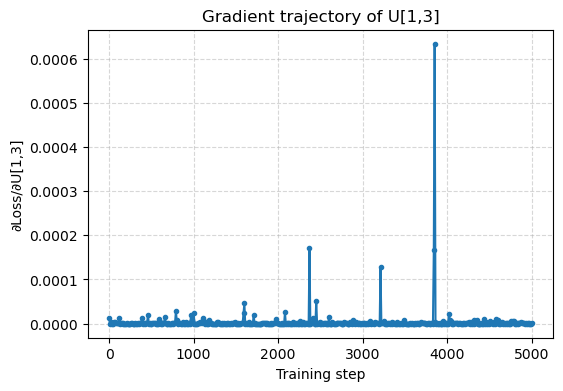

In [12]:
import matplotlib.pyplot as plt 
grad_history = info["grad_history"]
i, j = 1, 3
steps = [entry["step"] for entry in grad_history]
grad_vals = [entry["U_grad"][i, j].item() for entry in grad_history]

plt.figure(figsize=(6,4))
plt.plot(steps, grad_vals, marker='.', linewidth=1.5)
plt.xlabel("Training step")
plt.ylabel(f"∂Loss/∂U[{i},{j}]")
plt.title(f"Gradient trajectory of U[{i},{j}]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

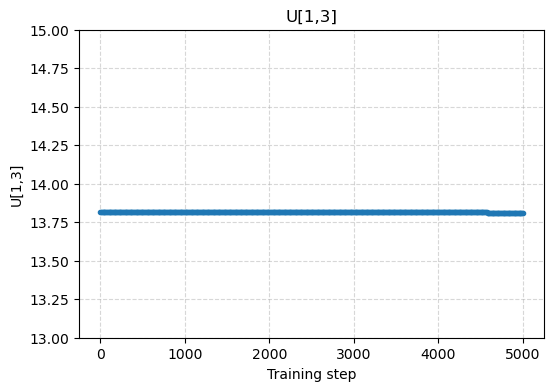

In [17]:
history = info["history"]
i, j = 1, 3
steps = [entry["step"] for entry in grad_history]
Uij_val = [entry["U"][i, j].item() for entry in history]

plt.figure(figsize=(6,4))
plt.ticklabel_format(axis="y", style="plain", useOffset=False)
plt.ylim(13,15)
plt.plot(steps, Uij_val, marker='.', linewidth=1.5)
plt.xlabel("Training step")
plt.ylabel(f"U[{i},{j}]")
plt.title(f"U[{i},{j}]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


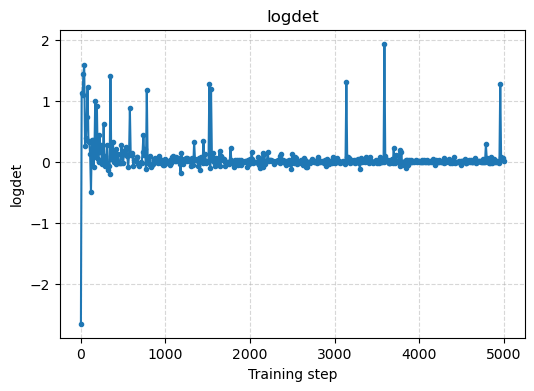

In [14]:
steps = [entry["step"] for entry in history]
logdet = [entry["logdet"] for entry in history]

plt.figure(figsize=(6,4))
plt.plot(steps, logdet, marker='.', linewidth=1.5)
plt.xlabel("Training step")
plt.ylabel(f"logdet")
plt.title(f"logdet")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

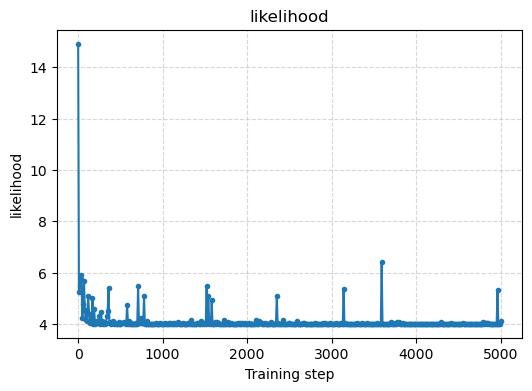

In [15]:
steps = [entry["step"] for entry in history]
likelihood = [entry["likelihood"] for entry in history]

plt.figure(figsize=(6,4))
plt.plot(steps, likelihood, marker='.', linewidth=1.5)
plt.xlabel("Training step")
plt.ylabel(f"likelihood")
plt.title(f"likelihood")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

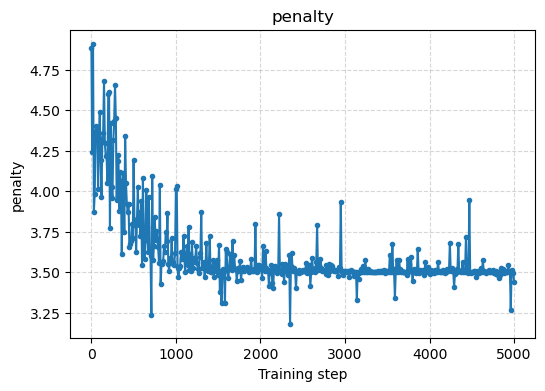

In [7]:
steps = [entry["step"] for entry in history]
penalty = [entry["penalty"] for entry in history]

plt.figure(figsize=(6,4))
plt.plot(steps, penalty, marker='.', linewidth=1.5)
plt.xlabel("Training step")
plt.ylabel(f"penalty")
plt.title(f"penalty")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [8]:
# d=2
import logging
import numpy as np

from torch.utils.data import Dataset

from synthetic_dataset import SyntheticDataset
from synthetic_dataset import dataset_based_on_B


# Load dataset
n, d = 10000, 2
graph_type, degree = 'ER', 1    # ER1 graph
B_scale = 1.0
noise_type = 'gaussian_ev'

Dataset = SyntheticDataset(n, d, graph_type, degree,
                          noise_type, B_scale, seed=42)
data = Dataset.X
R_hat = np.cov(data.T)
print(R_hat.shape)
d = R_hat.shape[0]
Omega_true = np.eye(d)
Theta_hat = inv(R_hat)
# A_init = np.linalg.cholesky(Theta_hat)
# A_init = A_init + 0.01 * np.random.randn(*A_init.shape)
np.random.seed(54)
B_init = np.random.randn(*R_hat.shape)
B_true = Dataset.B
G_true = Dataset.B_bin
beta = 5
lam = 0.5

A_true = (np.eye(d) - B_true) @ inv(sqrtm(Omega_true))
print("G_true = \n",G_true)
likelihood_true = - 2 * np.log(np.linalg.det(A_true)) + np.trace(A_true.T @ R_hat @ A_true)
print("likelihood_true = ", likelihood_true)
true_penalty = lam * np.count_nonzero(A_true[~np.eye(A_true.shape[0], dtype=bool)])
f_true = likelihood_true + true_penalty

B_final,G_final, info = train_gumbel_sgd(
    Rhat_np = R_hat,
    lam = lam,
    delta = 1e-6,
    tau_start = 1,
    tau_end = 1,
    B_init = B_init,
    max_steps = 500,
    history_every=1,
    seed = 1
)
    
print("G_est = \n",G_final)
print("U_init = \n", np.array2string(info["U_init"], formatter={'float_kind':lambda x: f"{x:.2f}"}))
print("U_final = \n", np.array2string(info["U_final"], formatter={'float_kind':lambda x: f"{x:.2f}"}))
print("P_final = \n", np.array2string(info["P_final"], formatter={'float_kind':lambda x: f"{x:.2f}"}))
print("Final Loss = ", info["final_loss"])
print("Final penalty = ", info["final_penalty"])
print("Final likelihood = ", info["final_likelihood"])
print("likelihood_true = ", likelihood_true)


(2, 2)
G_true = 
 [[0. 1.]
 [0. 0.]]
likelihood_true =  1.9932488151504195
G_est = 
 [[0. 1.]
 [0. 0.]]


KeyError: 'U_init'

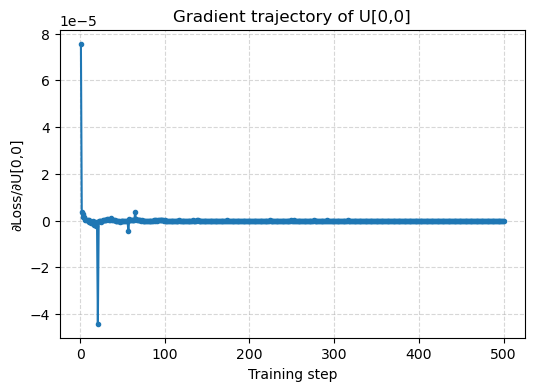

In [ ]:
import matplotlib.pyplot as plt 
grad_history = info["grad_history"]
i, j = 0, 0
steps = [entry["step"] for entry in grad_history]
grad_vals = [entry["U_grad"][i, j].item() for entry in grad_history]

plt.figure(figsize=(6,4))
plt.plot(steps, grad_vals, marker='.', linewidth=1.5)
plt.xlabel("Training step")
plt.ylabel(f"∂Loss/∂U[{i},{j}]")
plt.title(f"Gradient trajectory of U[{i},{j}]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

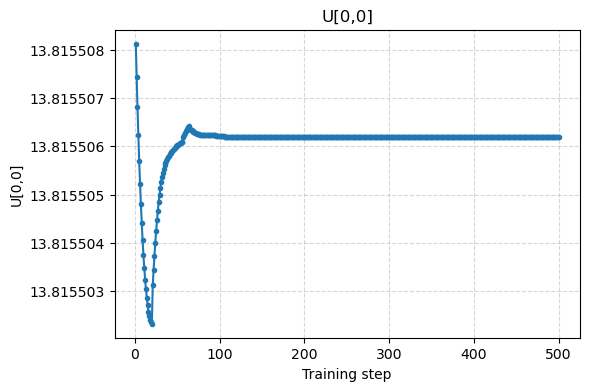

In [ ]:
history = info["history"]
i, j = 0, 0
steps = [entry["step"] for entry in grad_history]
Uij_val = [entry["U"][i, j].item() for entry in history]
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(steps, Uij_val, marker='.')
ax.set_title("U[0,0]")
ax.set_xlabel("Training step")
ax.set_ylabel("U[0,0]")

# 关闭科学计数和offset
ax.ticklabel_format(axis='y', style='plain', useOffset=False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

ax.grid(True, linestyle='--', alpha=0.5)
plt.show()